In [1]:
#imports
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
splat.initializeStandards()
import seaborn as sns
import popsims
splat.initializeStandards(all=True)
from scipy.interpolate import interp1d
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%matplotlib inline


/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
ABS_MAG_FILE=popsims.DATA_FOLDER+'/absmag_relations.pkl'

In [3]:
 KVALS={'2MASS_KS': {\
            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
            'rms': np.zeros(65)+0.05}}

In [4]:
sptgrid=np.arange(10, 41, 100)

In [5]:
from popsims.filtermags import filterMag

In [6]:
def get_colors(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = filterMag(sp.wave, sp.flux, sp.noise, sp.flux.unit, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = filterMag(sp.wave, sp.flux, sp.noise, sp.flux.unit, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

def get_colors_splat(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = splat.filterMag(sp, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

In [7]:
sp=splat.getSpectrum(lucky=True)[0]


Retrieving 1 lucky file



In [8]:
get_colors(sp, 'VISTA_KS', '2MASS J')

(1.189173614447963, 0.012360465808439705)

In [9]:
#ghjbk

In [10]:
#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.5) | (splat_db.J_2MASS_E > 0.5)) ]

#sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [11]:
#verified list of sds


In [12]:
#get y dwarfs
def get_shortname(n):
        return splat.designationToShortName(n).replace('J', 'WISE')

schn='/Volumes/Lacie/schneider/*.txt'
schntb=pd.read_csv('/Volumes/Lacie/wispsdata/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [13]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

In [14]:
#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

In [15]:
def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df

In [16]:
#tdwarfs.MEDIAN_SNR

In [17]:
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [18]:
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [19]:
def get_file(x):
    try:
        return splat.getSpectrum(filename=x)[0]
    except:
        return 

In [20]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: get_file(x))
#sds_spectra=sds.DATA_FILE.apply(lambda x:  get_file(x))


#all_spectra=pd.read_pickle('/users/caganze/research/popsims/data/splat_spectra.pkl')
#sd_spectra=pd.read_pickle('/users/caganze/research/popsims/data/sd_spectra.pkl')

In [21]:
schntb['spectra']=[x[0] for x in  spectra_schn]

schntb['snr']=[x[1] for x in  spectra_schn]

schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

all_spectra=np.concatenate([templs,schntb.spectra.values ])
#all_spectra=templs

In [22]:
#import pickle
#output = open('/users/caganze/research/popsims/data/splat_spectra.pkl', 'wb')
#pickle.dump(all_spectra, output)
#output.close()

#import pickle
#output = open('/users/caganze/research/popsims/data/sd_spectra.pkl', 'wb')
#pickle.dump(sds_spectra, output)
#output.close()


In [23]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [24]:
spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
                     schntb.Spec.apply(make_spt_number).values,
                    ])
#spts=smlf.SPEX_TYPE.apply(make_spt_number).values

In [25]:
assert len(spts) == len(all_spectra)

In [26]:
#ascii.write?

In [27]:
#for f in glob.glob('/volumes/LaCie/popsimsdata/popsims/filters/*.dat'):
#    d=ascii.read(f,names=['LAM', 'TRANSMISSION'])
#    d['LAM']=d['LAM']/10_000
    #print (d)
#    ascii.write(d, f.replace('.dat', '.txt'), comment='#')
#    plt.plot(d['LAM'], d['TRANSMISSION'])
#    del d
    

In [28]:
#sds_spts=sds.SPEX_TYPE.apply(make_spt_number).values

In [29]:
dwarf_pairs={'NIRISS_F115W': {'ref': 'MKO J', 'method':'ab'},
            'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
            'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'},
            'VISTA_Z':{'ref': 'MKO J', 'method': 'vega'},
            'VISTA_Y':{'ref': 'MKO J', 'method': 'vega'},
           'VISTA_J':{'ref': 'MKO J', 'method': 'vega'},
            'VISTA_H':{'ref': '2MASS H', 'method': 'vega'},
            'VISTA_KS':{'ref': '2MASS H', 'method': 'vega'},
            'UKIDSS_Z':{'ref': 'MKO J', 'method': 'vega'},
            'UKIDSS_J':{'ref': 'MKO J', 'method': 'vega'},
            'UKIDSS_H':{'ref': '2MASS H', 'method': 'vega'},
           'UKIDSS_K':{'ref': '2MASS H', 'method': 'vega'}}


sd_pairs= {'NIRISS_F115W': {'ref': 'MKO J', 'method':'ab'},
            'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
            'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'},
            'VISTA_Z':{'ref': 'SDSS_Z', 'method': 'vega'},
            'VISTA_Y':{'ref': 'SDSS_Z', 'method': 'vega'},
            'VISTA_J':{'ref': 'MKO J', 'method': 'vega'},
            'VISTA_H':{'ref': '2MASS H', 'method': 'vega'},
            'VISTA_KS':{'ref': '2MASS K', 'method': 'vega'},
            'UKIDSS_Z':{'ref': 'SDSS_Z', 'method': 'vega'},
            'UKIDSS_J':{'ref': 'MKO J', 'method': 'vega'},
            'UKIDSS_H':{'ref': '2MASS H', 'method': 'vega'},
            'UKIDSS_K':{'ref': '2MASS K', 'method': 'vega'}}


In [30]:
#sd_absolute_mag(spt, 20)

In [31]:
splat.typeToNum

<function splat.utilities.typeToNum(inp, subclass='dwarf', error='', uncertainty=0.0, luminosity_class='', metallicity_class='', age_class='', color_class='', peculiar=False, verbose=False, **kwargs)>

In [32]:
#remove nones
nones= np.array(all_spectra)==None
all_spectra=all_spectra[~nones]
spts=spts[~nones]
assert len(spts) == len(all_spectra)

In [33]:
def compute_colors(sp, sd=False):
    fl_pairs=None
    if sd: fl_pairs=sd_pairs
    if not sd: fl_pairs=dwarf_pairs
    #sp.normalize()
    res={}
    for p in fl_pairs.keys():
        res.update({p+'and'+fl_pairs[p]['ref']: \
                    get_colors(sp, p, fl_pairs[p]['ref'])})
    return res

In [34]:
zhang_subds=pd.read_pickle( '/volumes/LaCie/popsimsdata/combined_sd_templates.pkl')
zhang_subds['spt']=zhang_subds.sptype.apply(make_spt_number)

In [35]:
optical_stds=pd.read_pickle('/volumes/LaCie/popsimsdata/combined_optical_templates.pkl')
optical_stds['spt']=optical_stds.sptype.apply(make_spt_number)

In [36]:
#aurora's templates
aurora= pd.read_pickle(popsims.DATA_FOLDER+'/aurora_templates.pkl')
aurora_dwarf_spectra = aurora.spectrum[aurora.is_dwarf].values
aurora_dwarf_spectypes= [splat.typeToNum(x) for x in aurora.proper_type[aurora.is_dwarf]]
aurora_subdwarf_spectra= aurora.spectrum[~aurora.is_dwarf].values
aurora_subdwarf_spectypes=[splat.typeToNum(x) for x in aurora.proper_type[~aurora.is_dwarf]]

In [37]:
#optical_stds

In [38]:
#only pick those ith sds or esd or usd in their sptype
zhang_subds=zhang_subds[np.logical_or.reduce([zhang_subds.sptype.str.startswith('esd'),\
                                             zhang_subds.sptype.str.startswith('sd'),\
                                              zhang_subds.sptype.str.startswith('usd')])]
#add 
optical_sd_bool=np.logical_or.reduce([optical_stds.sptype.str.startswith('esd'),\
                                    optical_stds.sptype.str.startswith('sd'),\
                                    optical_stds.sptype.str.startswith('usd')]).astype(bool)


In [39]:
zhang_subds=zhang_subds.append(optical_stds[optical_sd_bool])

In [40]:
#assert len(zhang_subds)==131

In [41]:
#zhang_subds.spt.values

In [42]:
#sd_df

In [43]:
optical_templates=optical_stds[~optical_sd_bool].spectra.values
optical_spts=optical_stds[~optical_sd_bool].spt.values

In [44]:
optical_templates=optical_templates[optical_spts>=10]
optical_spts=optical_spts[optical_spts>=10]

assert len(np.concatenate([optical_templates, all_spectra]))==\
len(np.concatenate([optical_spts, spts]))


In [45]:
len(zhang_subds.spectra.values), len( aurora_subdwarf_spectra)

(133, 12)

In [46]:
len(zhang_subds.spt.values), len(aurora_subdwarf_spectypes)

(133, 12)

In [47]:
sd_df=pd.DataFrame.from_records([compute_colors(x, sd=True) \
                                 for x in tqdm(np.concatenate([zhang_subds.spectra.values,\
                                                               aurora_subdwarf_spectra]))])
sd_df['spt']=np.concatenate([zhang_subds.spt.values, aurora_subdwarf_spectypes])

100%|█████████████████████████████████████████| 145/145 [00:28<00:00,  5.15it/s]


In [48]:
assert len(all_spectra)== len(spts)

In [49]:
df=pd.DataFrame.from_records([compute_colors(x, sd=False) 
                              for x in tqdm(np.concatenate([all_spectra,\
                                                        optical_templates, \
                                                            aurora_dwarf_spectra]))])

df['spt']=np.concatenate([spts,  optical_spts, aurora_dwarf_spectypes])

100%|█████████████████████████████████████████| 338/338 [03:37<00:00,  1.56it/s]


In [50]:
aurora_dwarf_spectra[-1].wave

<Quantity [0.36500496, 0.36501098, 0.36501718, ..., 1.0199542 , 1.019971  ,
           1.0199878 ] micron>

In [51]:
#compute_colors(aurora_dwarf_spectra[-1], sd=False)

In [52]:
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [53]:
rocio_coeffs={'SDSS_R':[-0.03, 1.3 , 7.2 , 0.62],\
              'SDSS_I':[-0.009, 0.9, 6.8, 0.55],\
              'SDSS_Z':[-0.005, 0.74, 6.7 ,  0.5]}

In [54]:
rocio_relations={}

In [55]:
rocio_coeffs['SDSS_R'][:-1]

[-0.03, 1.3, 7.2]

In [56]:
for k in rocio_coeffs.keys():
    s={k: {'x': 'spt', 'y': k, 'fit':np.poly1d(rocio_coeffs[k][:-1]), \
                'scatter': rocio_coeffs[k][-1], \
                'method': 'polynomial',\
                'range': [10, 24] ,
          'x0': 10}}
    rocio_relations.update(s)
    pass

In [57]:
rocio_relations['SDSS_R']['fit'](np.arange(16, 24)-10)

array([13.92, 14.83, 15.68, 16.47, 17.2 , 17.87, 18.48, 19.03])

In [58]:
from popsims.relations import absolute_mag_h, absolute_mag_j, LITERATURE_POLYNOMIALS

In [59]:
def get_jh_mamajek(spt):
    from astropy.io import ascii
    mamjk=ascii.read('/Volumes/LaCie/EEM_dwarf_UBVIJHK_colors_Teff.txt').to_pandas().replace('None', np.nan)
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush 
    
    spts=mamjk.SpT.apply(splat.typeToNum).apply(float).values
    
    fx_j=interp1d(spts, js, assume_sorted = False, fill_value = np.nan, bounds_error=False)
    fx_h=interp1d(spts, hs, assume_sorted = False, fill_value = np.nan, bounds_error=False)
    return [ fx_j(spt), 0.4], [ fx_h(spt), 0.4] 

In [60]:
def mko_2mass_conversion(jmko, jerr):
    if np.logical_and(jmko > 10, jmko <20):
        pol=LITERATURE_POLYNOMIALS['kirkpatrick2021']['x=j_2mass,y=j_mko']
        b, m=pol['10_20']['coeffs']
        unc= pol['10_20']['yerr']
        y= np.random.normal(jmko, (jerr**2+unc**2)**0.5, 1000)
        x= (y-b)/m
        return np.nanmedian(x), np.nanstd(x)
    else:
        return np.nan, np.nan

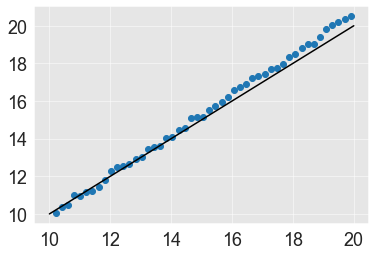

In [61]:
fig, ax=plt.subplots()
xvalues=np.linspace(10, 30, 100)
y=np.vstack([mko_2mass_conversion(x, 0.2*x) for x in xvalues])
ax.scatter(xvalues, y[:,0])
ax.plot([10, 20], [10, 20], c='k')

In [62]:
import splat.empirical as spe

In [63]:
def get_absolute_mag_h2mass(spt):
    #use mamajek for < m5
    if spt <= 16:
        return get_jh_mamajek(spt)[-1]
    if (spt >16) & (spt<38):
        return spe.typeToMag(spt, '2MASS H', ref='dupuy2012')
    if spt >=38:
        return absolute_mag_h(spt, ref='kirkpatrick2021', syst='2mass')

def get_absolute_mag_j2mass(spt):
    if spt <= 16:
        return get_jh_mamajek(spt)[0]
    if (spt >16) & (spt<38):
        return spe.typeToMag(spt, 'MKO J', ref='dupuy2012')
    if spt >=38:
        return absolute_mag_j(spt, ref='kirkpatrick2021', syst='mko')

In [64]:
get_absolute_mag_j2mass(41), absolute_mag_j(41, ref='kirkpatrick2021', syst='mko')

((23.42435503396468, 0.5954661936614173),
 (23.390302140599232, 0.6077647173943602))

In [65]:
xvals= np.linspace(10, 42, 100)
yvals0=np.vstack([get_absolute_mag_j2mass(x) for x in xvals])
yvals1=np.vstack([get_absolute_mag_h2mass(x) for x in xvals])

[Text(0, 0.5, 'H mag'), Text(0.5, 0, 'SpT')]

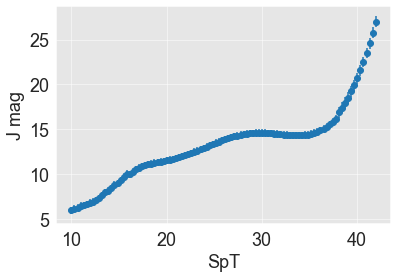

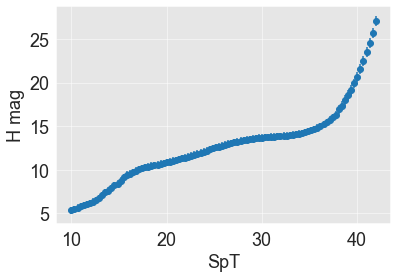

In [66]:
fig, ax=plt.subplots()
ax.errorbar(xvals, yvals0[:,0], yerr=yvals0[:,1], fmt='o')
ax.set(ylabel='J mag',  xlabel='SpT')

fig, ax=plt.subplots()
ax.errorbar(xvals, yvals1[:,0], yerr=yvals1[:,1], fmt='o')
ax.set(ylabel='H mag', xlabel='SpT')

In [67]:
 get_absolute_mag_j2mass(17)

(10.645930656199994, 0.39)

In [68]:
#use mamajek relations for earlier?

In [69]:
def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        pol=kirkpa2019pol[filt]['pol']
        unc=kirkpa2019pol[filt]['scatter']
        return pol(spt-30), unc

def get_subdwarf_abs_mag(spt, flter):
    m, munc=np.nan, np.nan
    #replace panstarrs by sdss
    m, munc=spe.typeToMag(spt, flter, reference='zhang2013')
        
    return m, munc
        
def get_abs_mag(spt, flter, method='vega'):
    #base absolute mag relations to use to convert from other absmag
    m, munc=(np.nan, np.nan)
    if ((flter.upper()=='MKO J') or (flter.upper()=='MKO_J')):
        corr=splat.photometry.vegaToAB('MKO J')
        m, munc=get_absolute_mag_j2mass(spt)
        if method == 'ab': m+corr
        
    if ((flter.upper()=='2MASS H') or (flter.upper()=='2MASS_H')):
        corr=splat.photometry.vegaToAB('2MASS H')
        m, munc=get_absolute_mag_h2mass(spt)#make_mamajek_fit(spt)
        if method == 'ab': m+corr
        #if spt <36:
        #    
        #    #m=BEST['2MASS H'][1](spt)
        #    #munc= np.nanmedian(best_dict[k]['rms'])
        #    #m, munc=spe.typeToMag(spt, '2MASS H')
        #    m, munc=get_absolute_mag_h2mass#make_mamajek_fit(spt)
        #    if method == 'ab': m+corr

        #else:
        #    m, munc=
        #    if method == 'ab': m+corr
        

    if ((flter.upper()=='2MASS KS') or (flter.upper()=='2MASS_KS')):
        corr=splat.photometry.vegaToAB('2MASS Ks')
        #m, munc= spe.typeToMag(spt, '2MASS J')
        m, munc=spe.typeToMag(spt, '2MASS Ks', ref='dupuy2012')
        if method == 'ab': m+corr
        
    if flter.upper().startswith('PANSTARRS'):
            corr=splat.photometry.vegaToAB(flter.upper())
            m, munc=spe.typeToMag(spt, flter.upper(), reference='best2018' )
            if method == 'ab': m+corr
    return m, munc

In [70]:
#import popsims
#popsims.get_distance(get_abs_mag(25, '2MASS J')[0], 28.)

In [71]:
sp_grid=np.arange(15, 42)

In [72]:
#BEST['range']['PANSTARRS_R'][-1]

In [73]:
#for spt in range(10, 40):
#    for f in ['2MASS J', '2MASS H', 'SDSS_Z']:
#        print(spt, f, get_subdwarf_abs_mag(spt, f)[0])

In [74]:
def get_abs_mags(row):
    res={}
    for p in dwarf_pairs.keys():
        cl=p+'and'+dwarf_pairs[p]['ref']
        v, ve=get_abs_mag(row.spt, dwarf_pairs[p]['ref'], method= dwarf_pairs[p]['method'])
        absm= row[cl][0]+v
        res.update({p: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)

def get_abs_mags_sd(row):
    res={}
    for p in sd_pairs.keys():
        cl=p+'and'+sd_pairs[p]['ref']
        v, ve=get_subdwarf_abs_mag(row.spt, sd_pairs[p]['ref'])
        absm= row[cl][0]+v
        res.update({p: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)
#def get_abs_mags_lsst_fromcolor(row):
#    res={}
#    for p in fl_pairs:

#        cl=p[0]+'and'+p[1]
#        v, ve=absolute_sdss(row.spt)[p[1]]
#        absm= row[cl][0]+v
#        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
  #  return pd.Series(res)

#def get_abs_mags_lsst_fromcolor_sds(row):
#    res={}
#    for p in fl_pairs:

 #       cl=p[0]+'and'+p[1]
 #       v, ve=sd_absolute_mag(row.spt)[p[1]]
 #       absm= row[cl][0]+v
 #       res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
 #   return pd.Series(res)
        
    

In [75]:
#get_subdwarf_abs_mag(20, '2MASS_J')

In [76]:
import splat.empirical as spe

In [77]:
tqdm.pandas()
abs_df=df.progress_apply(get_abs_mags, axis=1)

100%|█████████████████████████████████████████| 338/338 [01:23<00:00,  4.04it/s]


In [78]:
sd_abs_df=sd_df.progress_apply(get_abs_mags_sd, axis=1)

100%|████████████████████████████████████████| 145/145 [00:00<00:00, 291.47it/s]


In [79]:
#sd_abs_df

In [80]:
#FITS={'absmags':{'dwarfs':{}, 'subdwarfs':{}},\
#      'colors':{'dwarfs':{}, 'subdwarfs':{}},
#      'references':{}}
FITS= pd.read_pickle(ABS_MAG_FILE)

In [81]:
#best_relations={}
#for k in BEST['rms'].keys():
#    s={k: {'x': 'spt','y': k, 'fit':BEST[k][-1], 'scatter': BEST['rms'][k], \
#           'method': 'polynomial','range':  BEST['range'][k], 'x0':0}}
#    best_relations.update(s)


In [82]:
#best_relations.keys()

In [83]:
rocio_relations

{'SDSS_R': {'x': 'spt',
  'y': 'SDSS_R',
  'fit': poly1d([-0.03,  1.3 ,  7.2 ]),
  'scatter': 0.62,
  'method': 'polynomial',
  'range': [10, 24],
  'x0': 10},
 'SDSS_I': {'x': 'spt',
  'y': 'SDSS_I',
  'fit': poly1d([-0.009,  0.9  ,  6.8  ]),
  'scatter': 0.55,
  'method': 'polynomial',
  'range': [10, 24],
  'x0': 10},
 'SDSS_Z': {'x': 'spt',
  'y': 'SDSS_Z',
  'fit': poly1d([-5.0e-03,  7.4e-01,  6.7e+00]),
  'scatter': 0.5,
  'method': 'polynomial',
  'range': [10, 24],
  'x0': 10}}

In [84]:
#FITS

In [85]:
#FITS['references'].update({'kiman2019': rocio_relations })
#FITS['references'].update({'best2012': best_relations })

In [86]:
#FITS

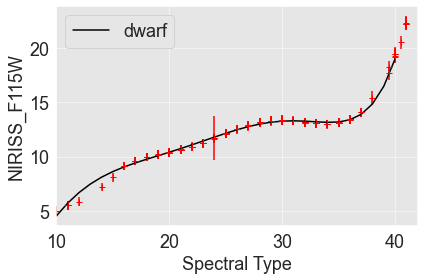

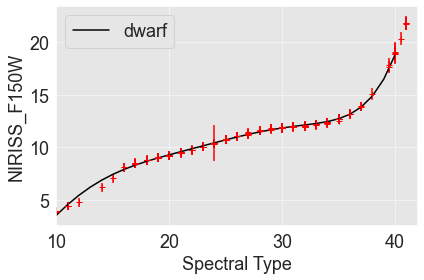

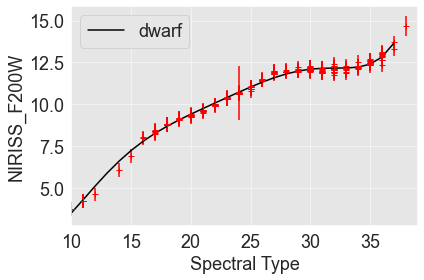

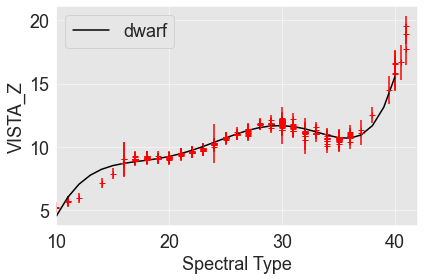

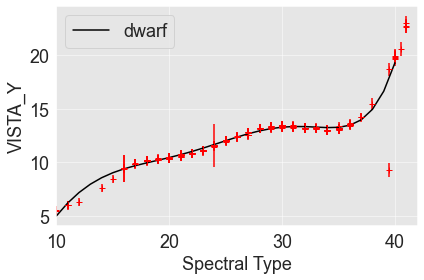

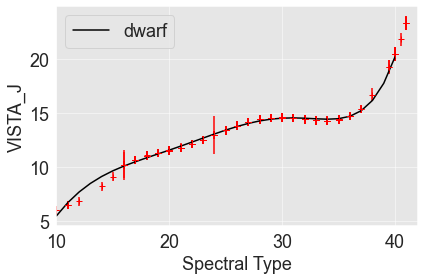

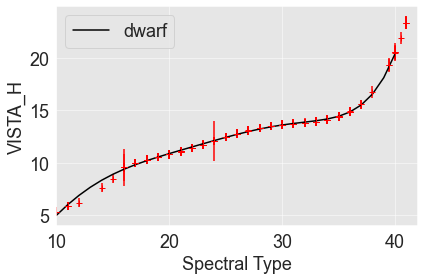

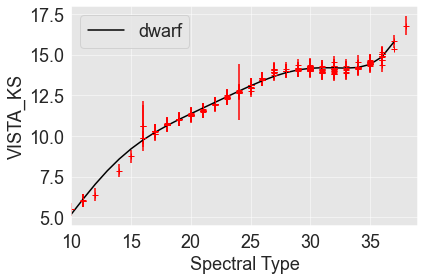

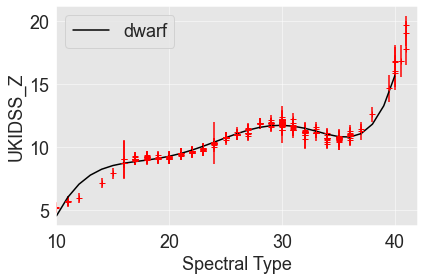

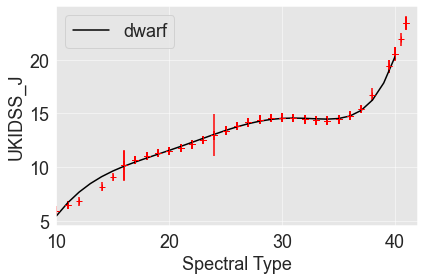

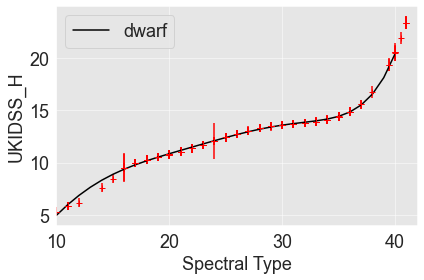

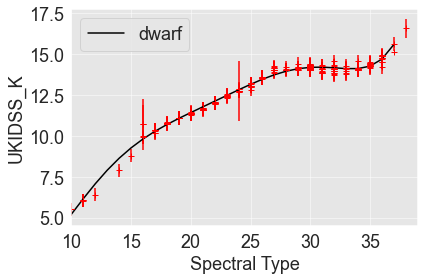

In [87]:
for c in abs_df.columns:
    try:
        if c=='spt':
            pass
        else:
            fig, a=plt.subplots()
            vals=np.vstack(abs_df[c].values)
            spts=df.spt.values

            #masks
            mask= np.logical_or.reduce([np.isnan(spts), 
                                        np.isnan(vals[:,0]),
                                        np.isnan(vals[:,1])])

            m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                          vals[:,0][~mask], 
                                          vals[:,1][~mask], 6, sigma=3.)
            FITS['absmags']['dwarfs'].update({c: {'x': 'spt',
                                                  'y': c,
                                                  'fit':fit, \
                                                  'scatter': np.nanmedian(vals[:,1]), \
                                                  'method': 'polynomial',\
                                                  'range':  (np.nanmin(spts[~mask]),\
                                                             np.nanmax(spts[~mask])), \
                                                 'x0':0}})


            spgrid=np.arange(np.nanmin(spts[~mask]), np.nanmax(spts[~mask]))
            a.plot(spgrid, fit(spgrid), c='k', label='dwarf')



            a.errorbar(spts, vals[:,0], fmt='+', 
                       yerr=vals[:,1], color='r')



            a.set_ylabel(c)
            a.set_xlabel('Spectral Type')
            a.legend()
            plt.tight_layout()
            a.set_xlim([np.nanmin(spts[~mask]),np.nanmax(spts[~mask])+1])
            #a.set_ylim([fit(np.nanmin(spgrid)), fit(np.nanmax(spgrid))])
            plt.savefig('../figures/abs_mag_relations{}.pdf'.format(c))
    except:
        print ('all empty {}'.format(c))
        pass 


all empty NIRISS_F115W
all empty VISTA_J
all empty UKIDSS_J


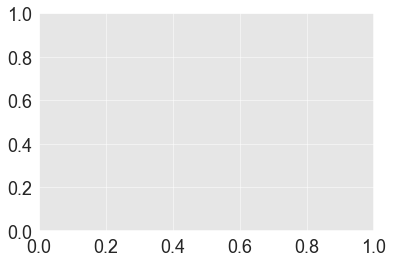

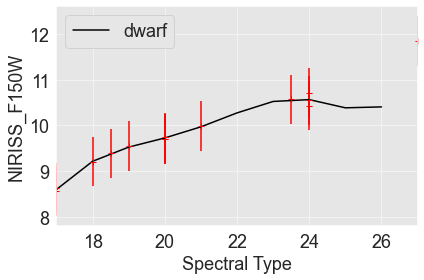

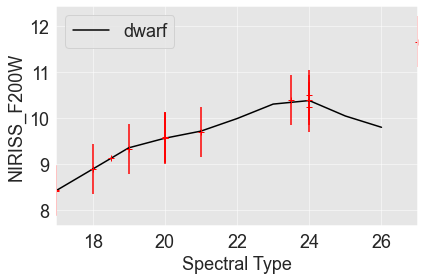

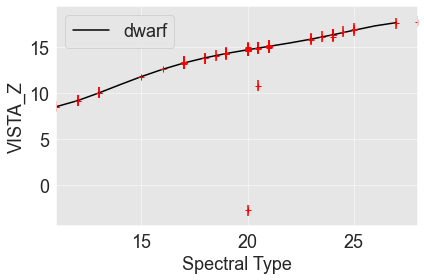

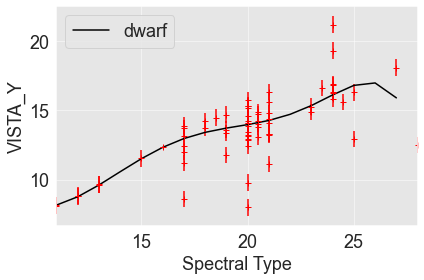

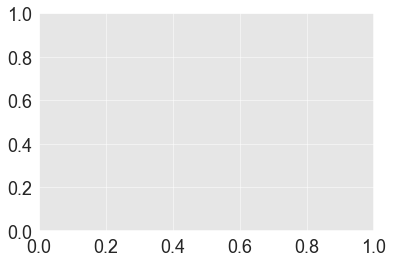

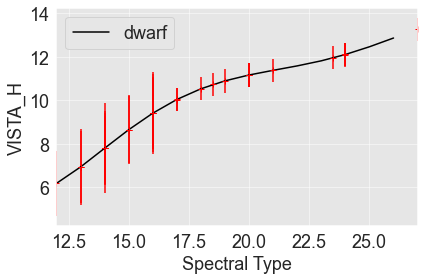

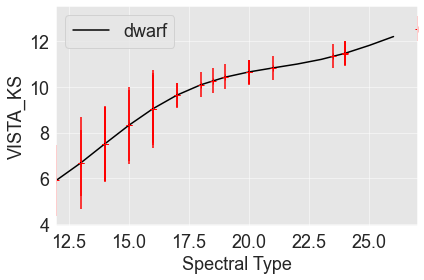

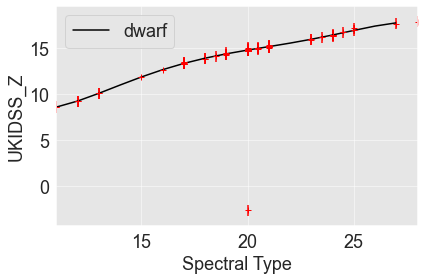

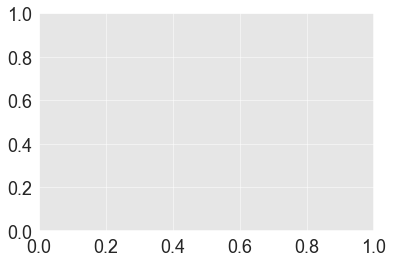

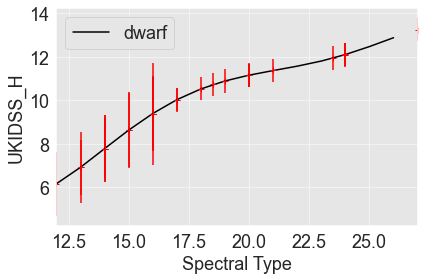

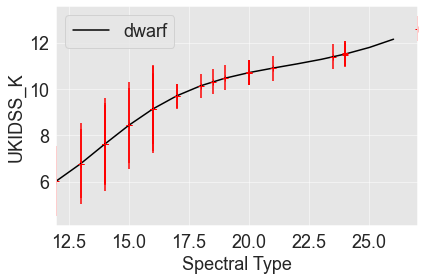

In [88]:
for c in sd_abs_df.columns:
    try:
        if c=='spt':
            pass
        else:
            fig, a=plt.subplots()
            vals=np.vstack(sd_abs_df[c].values)
            spts=sd_df.spt.values

            #masks
            mask= np.logical_or.reduce([np.isnan(spts), 
                                        np.isnan(vals[:,0]),
                                        np.isnan(vals[:,1])])

            m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                          vals[:,0][~mask], 
                                          vals[:,1][~mask], 6, sigma=3.)
            FITS['absmags']['subdwarfs'].update({c: {'x': 'spt',
                                                  'y': c,
                                                  'fit':fit, \
                                                  'scatter': np.nanmedian(vals[:,1]), \
                                                  'method': 'polynomial',\
                                                  'range':  (np.nanmin(spts[~mask]),\
                                                             np.nanmax(spts[~mask])), \
                                                 'x0':0}})


            spgrid=np.arange(np.nanmin(spts[~mask]), np.nanmax(spts[~mask]))
            a.plot(spgrid, fit(spgrid), c='k', label='dwarf')



            a.errorbar(spts, vals[:,0], fmt='+', 
                       yerr=vals[:,1], color='r')



            a.set_ylabel(c)
            a.set_xlabel('Spectral Type')
            a.legend()
            plt.tight_layout()
            a.set_xlim([np.nanmin(spts[~mask]),np.nanmax(spts[~mask])])
            plt.savefig('../figures/abs_mag_relations{}_sd.pdf'.format(c))
    except:
        print ('all empty {}'.format(c))
        pass 


In [89]:
FITS

{'absmags': {'dwarfs': {'NIRISS_F115W': {'x': 'spt',
    'y': 'NIRISS_F115W',
    'fit': poly1d([ 4.29713588e-07, -5.04229648e-05,  2.22068501e-03, -4.37392153e-02,
            3.02230231e-01,  1.75203666e+00, -1.70701962e+01]),
    'scatter': 0.3903172591457912,
    'method': 'polynomial',
    'range': (10.0, 41.0),
    'x0': 0},
   'NIRISS_F150W': {'x': 'spt',
    'y': 'NIRISS_F150W',
    'fit': poly1d([ 3.81506552e-07, -4.80917601e-05,  2.37805487e-03, -5.74753589e-02,
            6.67409384e-01, -2.38264132e+00, -1.22005576e+00]),
    'scatter': 0.40046259953749974,
    'method': 'polynomial',
    'range': (10.0, 41.0),
    'x0': 0},
   'NIRISS_F200W': {'x': 'spt',
    'y': 'NIRISS_F200W',
    'fit': poly1d([ 7.59609823e-07, -1.00377706e-04,  5.31740074e-03, -1.43601133e-01,
            2.05416628e+00, -1.39462050e+01,  3.72959094e+01]),
    'scatter': 0.40050122500935215,
    'method': 'polynomial',
    'range': (10.0, 38.0),
    'x0': 0},
   'VISTA_Z': {'x': 'spt',
    'y': 'VIST

In [90]:
#abs_df.keys()

In [91]:
#def fit_nsigma():
#    return 

In [92]:
#POLYNOMIALS=FITS

In [93]:
#ir=np.vstack(abs_df.LSST_I)[:,0]-np.vstack(abs_df.LSST_R)[:,0]

In [94]:
#h=plt.hist(ir)

In [95]:
#e(spts_m, d=np.ones_like(spts_m)*1000, keys=['LSST_Z', 'LSST_R'], object_type='dwarfs')

In [96]:
#updating WISE
#wise_dict=splat.SPT_ABSMAG_RELATIONS['best2018']['filters']['WISE_W1']
#_, fit_2massk=fit_with_nsigma_clipping(np.array(KVALS['2MASS_KS']['spt']), 
#                                      np.array( KVALS['2MASS_KS']['values']), 
#                                      np.array( KVALS['2MASS_KS']['rms'])
#                                     , 6, sigma=5.)
#add wise relations

#_, fit_wise1=fit_with_nsigma_clipping(np.array(wise_dict['spt']), 
#                                      np.array( wise_dict['values']), 
#                                      np.array( wise_dict['rms'])
#                                     , 6, sigma=5.)
#            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
#            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
#            'rms': np.zeros(65)+0.05}})

In [97]:
#df.spt.values.min()

In [98]:
#get_kirkpatrick_wise(30-10)

In [99]:
#spts_grids=np.linspace(17, 44, 1000)
#w1s=np.array([get_kirkpatrick_wise(x) for x in spts_grids])

In [100]:
#_, fit_wise=fit_with_nsigma_clipping(np.array(spts_grids), 
#                                      np.array(w1s), 
#                                      np.ones(len(w1s))*0.63
#                                     , 6, sigma=5.)
#plt.plot(spts_grids, w1s)
#plt.plot(spts_grids,fit_wise(spts_grids) )


In [101]:
#vals=np.vstack(abs_df['WFC3_F160W'].values)
#spts=df.spt.values
#plt.plot(spts, vals[:,0], 'o')

In [102]:
#FITS['2MASS_K']=(fit_2massk, np.nanmedian(np.array( KVALS['2MASS_KS']['rms'])))
#FITS['WISE_W1']=(fit_wise, 0.63)

In [103]:
#ADD WILL BEST 
best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]},
       
        'PANSTARRS_R': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,28], \
            'values': [15.37,16.76,17.74,18.14,18.37,18.74,19.02,19.61,20.60,20.74,21.21,22.88],\
            'rms': [0.43,0.50,0.51,0.37,0.31,0.28,0.29,0.39,0.56,0.37,0.78,0.5]},
        'PANSTARRS_I': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35], \
            'values': [13.25,14.18,15.00,15.62,16.00,16.41,16.73,17.40,18.35,18.71,19.27,20.09,20.38,20.09,20.22,21.10,21.97,22.69],\
            'rms': [0.34,0.39,0.48,0.39,0.26,0.25,0.26,0.34,0.38,0.33,0.65,0.36,0.79,0.5,1.14,0.5,0.5,0.5]},
        'PANSTARRS_Z': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [12.27,12.98,13.61,14.17,14.52,14.93,15.30,15.88,16.68,16.94,17.35,18.18,18.10,17.69,17.98,18.84,18.26,18.08,18.02,19.20,19.82,21.17,21.52,21.82],\
            'rms': [0.32,0.34,0.45,0.37,0.25,0.23,0.24,0.21,0.33,0.29,0.62,0.26,0.22,0.73,0.5,0.21,0.23,0.25,0.39,0.22,0.32,0.78,0.52,0.5]},
        'PANSTARRS_Y': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [11.76,12.31,12.81,13.23,13.58,13.97,14.33,14.89,15.66,15.87,16.27,17.13,17.04,16.57,16.77,17.45,16.75,16.50,16.32,17.43,18.06,19.34,19.75,20.37],\
            'rms': [0.30,0.31,0.43,0.36,0.23,0.21,0.24,0.29,0.32,0.28,0.61,0.25,0.21,0.72,0.5,0.16,0.13,0.22,0.38,0.18,0.32,0.81,0.59,0.5]}}

BEST={}
BEST['rms']={}
BEST['range']={}
for k in best_dict.keys():
    BEST[k]=fit_with_nsigma_clipping(np.array(best_dict[k]['spt']), 
                                      np.array(best_dict[k]['values']), 
                                      np.array(best_dict[k]['rms'])
                                     , 6, sigma=5.)
    BEST['rms'][k]=np.nanmedian(best_dict[k]['rms'])
    BEST['range'][k]=[np.nanmin(best_dict[k]['spt']), np.nanmax(best_dict[k]['spt'])]

FITS['references']['best2012']={}
for k in BEST['rms'].keys():
    s={k: {'x': 'spt','y': k, 'fit':BEST[k][-1], 'scatter': BEST['rms'][k], \
           'method': 'polynomial','range':  BEST['range'][k], 'x0':0}}
    
    FITS['references']['best2012'].update(s)
    


In [104]:
FITS

{'absmags': {'dwarfs': {'NIRISS_F115W': {'x': 'spt',
    'y': 'NIRISS_F115W',
    'fit': poly1d([ 4.29713588e-07, -5.04229648e-05,  2.22068501e-03, -4.37392153e-02,
            3.02230231e-01,  1.75203666e+00, -1.70701962e+01]),
    'scatter': 0.3903172591457912,
    'method': 'polynomial',
    'range': (10.0, 41.0),
    'x0': 0},
   'NIRISS_F150W': {'x': 'spt',
    'y': 'NIRISS_F150W',
    'fit': poly1d([ 3.81506552e-07, -4.80917601e-05,  2.37805487e-03, -5.74753589e-02,
            6.67409384e-01, -2.38264132e+00, -1.22005576e+00]),
    'scatter': 0.40046259953749974,
    'method': 'polynomial',
    'range': (10.0, 41.0),
    'x0': 0},
   'NIRISS_F200W': {'x': 'spt',
    'y': 'NIRISS_F200W',
    'fit': poly1d([ 7.59609823e-07, -1.00377706e-04,  5.31740074e-03, -1.43601133e-01,
            2.05416628e+00, -1.39462050e+01,  3.72959094e+01]),
    'scatter': 0.40050122500935215,
    'method': 'polynomial',
    'range': (10.0, 38.0),
    'x0': 0},
   'VISTA_Z': {'x': 'spt',
    'y': 'VIST

In [105]:
import pickle
output = open(ABS_MAG_FILE, 'wb')
pickle.dump(FITS, output)
output.close()

In [107]:
#FITS['references']['kiman2019']

In [108]:
zhang_subds.spectra.values

array([ spectrum of ULAS_J021642.96+004005.7_sdL4_Xshooter_VIS_Primeval-I.fits,
        spectrum of ULAS_J223302.03+062030.8_esdL0.5_Xshooter_VIS_Primeval-IV.fits,
        spectrum of ULAS_J141203.85+121609.9_sdL5_Xshooter_NIR_Primeval-IV.fits,
        spectrum of ULAS_J010756.85+100811.3_sdM7_OSIRIS_GTC63-13A_Primeval-IV.fits,
        spectrum of SDSS_J010448.46+153501.8_usdL1.5_Xshooter_NIR_Primeval-II.fits,
        spectrum of ULAS_J021642.96+004005.7_sdL4_Xshooter_NIR_Primeval-I.fits,
        spectrum of ULAS_J231924.35+052524.5_esdL1_OSIRIS_GTC39-12B_Primeval-IV.fits,
        spectrum of ULAS_J141203.85+121609.9_sdL5_OSIRIS_GTC39-12B_Primeval-IV.fits,
        spectrum of ULAS_J082206.61+044101.8_sdL0.5_OSIRIS_GTC39-12B_Primeval-IV.fits,
        spectrum of ULAS_J130710.22+151103.4_sdL8_OSIRIS_GTC46-14A_Primeval-IV.fits,
        spectrum of ULAS_J154638.34-011213.0_sdL3_OSIRIS_GTC63-13A_Primeval-IV.fits,
        spectrum of ULAS_J020628.22+020255.6_sdM7_OSIRIS_GTC39-12B_Primeval-IV